In [1]:
import pickle
import numpy as np
import xarray as xa
import cartopy
from cartopy import crs as ccrs
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import scipy.stats
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

/global/homes/d/duan0000/.conda/envs/duan/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def start_end_time(sub_id):
    start = []
    end = []
    ext_times = ext_days[sub_id]
    length = len(ext_times)
    i = 0
    while i <= length - 1:
        j = 1
        while (j + i <= length - 1) and ((ext_times[i + j] - ext_times[i + j - 1]) / np.timedelta64(1, "D") == 1):
            j += 1
        start.append(ext_times[i] - np.timedelta64(12, "h"))
        end.append(ext_times[i + j - 1] + np.timedelta64(12, "h"))
        i += j
    return start, end

In [3]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)
data = xa.open_dataarray('cpc-global/NAM_sub_precip', engine='netcdf4')
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))
ext_days = {}
for sub_id in range(1, 8):
    print("sub_id: ", sub_id)
    precip = monsoon_precip.sel(sub_id=sub_id)
    precip_data = precip.data
    q1 = np.quantile(precip_data[precip_data > 1], 0.05)
    q2 = np.quantile(precip_data[precip_data > 1], 0.95)
    ext_time = precip.where(precip > q2, drop=True).time.data
    print(len(ext_time), q2)
    ext_days[sub_id] = ext_time


sub_id:  1
39 21.363590636973544
sub_id:  2
38 7.98353434112839
sub_id:  3
37 7.6309751208430425
sub_id:  4
77 6.2968948209451305
sub_id:  5
118 6.469523059079158
sub_id:  6
124 10.647874758983226
sub_id:  7
153 17.252742222601025


# Number of Event days
* number of epe days, instead of number of epes. (consecutive days are counted multiple times)

In [4]:
def mk_score(x, n):
    s = 0
    demo = np.ones(n)
    for k in range(n-1):
        s = s+np.sum(demo[k+1:n][x[k+1:n] > x[k]])-np.sum(demo[k+1:n][x[k+1:n] < x[k]])
    return s

def variance_s(x, n):
    unique_x = np.unique(x)
    g = len(unique_x)
    if n==g:
        var_s = (n*(n-1)*(2*n+5))/18
    else:
        tp = np.zeros(unique_x.shape)
        demo = np.ones(n)
        for i in range(g):
            tp[i] = np.sum(demo[x==unique_x[i]])
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18
    return var_s

def z_score(s, var_s):
    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    return z

def p_value(z, alpha):
    # two tail test
    p = 2*(1-norm.cdf(abs(z)))  
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
    
    return p, h, trend

In [5]:
def sens_slope(x):
    """
    This method proposed by Theil (1950) and Sen (1968) to estimate the magnitude of the monotonic trend. Intercept calculated using Conover, W.J. (1980) method.
    Input:
        x:   a one dimensional vector (list, numpy array or pandas series) data
    Output:
        slope: Theil-Sen estimator/slope
        intercept: intercept of Kendall-Theil Robust Line
    Examples
    --------
      >>> import numpy as np
	  >>> import pymannkendall as mk
      >>> x = np.random.rand(120)
      >>> slope,intercept = mk.sens_slope(x)
    """
    # res = namedtuple('Sens_Slope_Test', ['slope','intercept'])
    
#     x, n = __missing_values_analysis(x, method = 'skip')
    n = len(x)
    slope = np.nanmedian(sens_estimator(x))
    intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
    
    return slope, intercept
def sens_estimator(x):
    idx = 0
    n = len(x)
    print(n)
    d = np.ones(int(n*(n-1)/2))

    for i in range(n-1):
        j = np.arange(i+1,n) # all the combination of two points selected from original series. 
        d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)
        idx = idx + len(j)
        # print(i, idx)
    return d

# Sub1

39
40
0.03358921951061755 True increasing
0.0 1.0


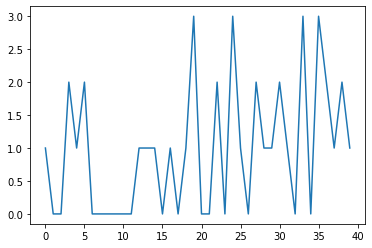

In [6]:
sub_id = 1
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    # print(len(ext_time), q2)
    n_epe.append(len(ext_time))
    
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)
plt.plot(n_epe)

In [7]:
import statsmodels.api as sm
from scipy import stats

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.379
Date:                Fri, 02 Jun 2023   Prob (F-statistic):             0.0259
Time:                        15:31:48   Log-Likelihood:                -53.590
No. Observations:                  40   AIC:                             111.2
Df Residuals:                      38   BIC:                             114.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3878      0.294      1.318      0.1

In [8]:
model = LinearRegression().fit(np.arange(n).reshape(-1, 1), n_epe)
print(model.coef_)


[0.03011257]


## find categories

In [9]:
import pandas as pd
def find_categories_events(label, end, start):
    years = np.arange(1979, 2019)
    cate_end = []
    for year in years:
        count = 0
        for i in range(len(end)):
            if (pd.to_datetime(end[i]).year==year)and(label[i]>0):
                count+=(end[i]-start[i])/np.timedelta64(1, 'D')
        cate_end.append(count)
    return cate_end

## Categories

In [10]:
sub_id = 1
surge_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
# tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
# tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
MCS_induced_flag = np.load("ERA5/PAU/MCS_" + str(sub_id) + ".npy")
MCS_induced_flag[MCS_induced_flag < 0] = 0
midtro_flag = np.load("ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
front_flag = np.load("ERA5/PAU/" + str(sub_id) + "_front.npy")
start, end = start_end_time(sub_id)
all_time = ext_days[sub_id]

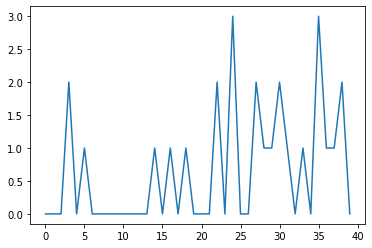

40
26.0  Sum n_epe
20.0  Sum Category
40
0.011629652484893782 False no trend
0.0 0.0


In [11]:
# TC
n_epe = find_categories_events(tc_induced_flag, end, start)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(n)
print(np.sum(n_epe), ' Sum n_epe')
print(np.sum(tc_induced_flag), ' Sum Category')
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

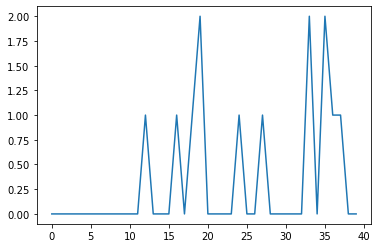

40
13.0  Sum n_epe
20.0  Sum Category
40
0.04764589634816807 False no trend
0.0 0.0


In [12]:
# TUTT
n_epe = find_categories_events(tutt_induced_flag, end, start)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(n)
print(np.sum(n_epe), ' Sum n_epe')
print(np.sum(tc_induced_flag), ' Sum Category')
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

# Sub2

In [13]:
sub_id = 2
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    # print(len(ext_time), q2)
    n_epe.append(len(ext_time))
print(np.sum(n_epe))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

38
40
0.10906651007833923 False no trend
0.0 0.0


In [14]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.244
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.142
Time:                        15:31:49   Log-Likelihood:                -69.943
No. Observations:                  40   AIC:                             143.9
Df Residuals:                      38   BIC:                             147.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5207      0.443      3.434      0.0

# Sub3

In [15]:
sub_id = 3
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    # print(len(ext_time), q2)
    n_epe.append(len(ext_time))
print(np.sum(n_epe), ' ', len(ext_days[sub_id]))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

37   37
40
0.1437289753329294 False no trend
0.0 0.0


In [16]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.603
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.115
Time:                        15:31:49   Log-Likelihood:                -66.845
No. Observations:                  40   AIC:                             137.7
Df Residuals:                      38   BIC:                             141.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4939      0.410      3.645      0.0

# Sub4

In [17]:
sub_id = 4
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    # print(len(ext_time), q2)
    n_epe.append(len(ext_time))
print(np.sum(n_epe), ' ', len(ext_days[sub_id]))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

77   77
40
0.1552667515887256 False no trend
0.0 2.0


In [18]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.821
Date:                Fri, 02 Jun 2023   Prob (F-statistic):             0.0580
Time:                        15:31:50   Log-Likelihood:                -77.594
No. Observations:                  40   AIC:                             159.2
Df Residuals:                      38   BIC:                             162.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0232      0.536      1.908      0.0

# Sub5

In [19]:
sub_id = 5
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    # print(len(ext_time), q2)
    n_epe.append(len(ext_time))
print(np.sum(n_epe), ' ', len(ext_days[sub_id]))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

118   118
40
0.9428745298807781 False no trend
0.0 3.0


In [20]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.6787
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.415
Time:                        15:31:50   Log-Likelihood:                -91.204
No. Observations:                  40   AIC:                             186.4
Df Residuals:                      38   BIC:                             189.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4159      0.753      3.206      0.0

# Sub6

In [21]:
sub_id = 6
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    # print(len(ext_time), q2)
    n_epe.append(len(ext_time))
print(np.sum(n_epe), ' ', len(ext_days[sub_id]))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

124   124
40
0.031150731982456437 True increasing
0.06451612903225806 0.7419354838709677


In [22]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.068
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.308
Time:                        15:31:50   Log-Likelihood:                -93.298
No. Observations:                  40   AIC:                             190.6
Df Residuals:                      38   BIC:                             194.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3939      0.794      3.015      0.0

In [23]:
model = LinearRegression().fit(np.arange(n).reshape(-1, 1), n_epe)
print(model.coef_)

[0.03621013]


## category

In [24]:
sub_id = 6
surge_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
# tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
# tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
MCS_induced_flag = np.load("ERA5/PAU/MCS_" + str(sub_id) + ".npy")
MCS_induced_flag[MCS_induced_flag < 0] = 0
midtro_flag = np.load("ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
front_flag = np.load("ERA5/PAU/" + str(sub_id) + "_front.npy")
start, end = start_end_time(sub_id)
all_time = ext_days[sub_id]

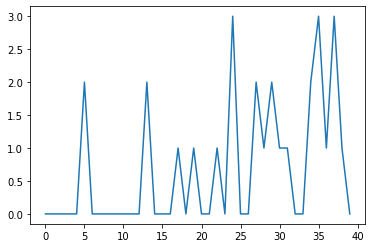

40
27.0  Sum n_epe
20.0  Sum Category
40
0.0024314296996508222 True increasing
0.0 0.0


In [25]:
# TC
n_epe = find_categories_events(tc_induced_flag, end, start)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(n)
print(np.sum(n_epe), ' Sum n_epe')
print(np.sum(tc_induced_flag), ' Sum Category')
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

# Sub7

In [26]:
sub_id = 7
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    # print(len(ext_time), q2)
    n_epe.append(len(ext_time))
print(np.sum(n_epe), ' ', len(ext_days[sub_id]))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

153   153
40
0.24838814471244408 False no trend
-0.035098522167487683 4.68442118226601


In [27]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.865
Date:                Fri, 02 Jun 2023   Prob (F-statistic):             0.0987
Time:                        15:31:51   Log-Likelihood:                -91.937
No. Observations:                  40   AIC:                             187.9
Df Residuals:                      38   BIC:                             191.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9427      0.767      6.441      0.0

# Precipitation Rates

In [28]:
def inspect_categoy_precip_rate(sub_id):
    surge_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
    # tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
    tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
    # tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
    tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
    MCS_induced_flag = np.load("ERA5/PAU/MCS_" + str(sub_id) + ".npy")
    MCS_induced_flag[MCS_induced_flag < 0] = 0
    midtro_flag = np.load("ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
    front_flag = np.load("ERA5/PAU/" + str(sub_id) + "_front.npy")
    start, end = start_end_time(sub_id)
    all_time = ext_days[sub_id]
    precip = monsoon_precip.sel(sub_id=sub_id)
    print('TC')
    label = tc_induced_flag
    cate_end = find_categories_events(label, end, start)
    # print(cate_end)
    year_precip = []
    for year in range(1979, 2019):
        total_precip = 0
        for i, day in enumerate(end):
            if (pd.to_datetime(end[i]).year==year)and(label[i]>0):
                delta_days = int((end[i]-start[i])/np.timedelta64(1, 'D'))
                for i in range(delta_days):
                    total_precip+=precip.sel(time=start[i]+np.timedelta64(12, 'h')+np.timedelta64(i, 'D'))
        year_precip.append(total_precip)
    daily_precip = []
    for i in range(len(year_precip)):
        if cate_end[i]>0:
            daily_precip.append(year_precip[i]/cate_end[i])
        else:
            daily_precip.append(0)
    plt.plot(daily_precip)
    plt.show()
    n = len(daily_precip)
    n_epe = np.array(daily_precip)
    s = mk_score(n_epe, n)
    var_s = variance_s(n_epe, n)
    Tau = s/(.5*n*(n-1))

    z = z_score(s, var_s)
    p, h, trend = p_value(z, alpha=0.05/6)
    slope, intercept = sens_slope(n_epe)
    print(p, h, trend)
    print(slope, intercept)
    print('TUTT')
    label = tutt_induced_flag
    cate_end = find_categories_events(label, end, start)
    # print(cate_end)
    year_precip = []
    for year in range(1979, 2019):
        total_precip = 0
        for i, day in enumerate(end):
            if (pd.to_datetime(end[i]).year==year)and(label[i]>0):
                delta_days = int((end[i]-start[i])/np.timedelta64(1, 'D'))
                for i in range(delta_days):
                    total_precip+=precip.sel(time=start[i]+np.timedelta64(12, 'h')+np.timedelta64(i, 'D'))
        year_precip.append(total_precip)
    daily_precip = []
    for i in range(len(year_precip)):
        if cate_end[i]>0:
            daily_precip.append(year_precip[i]/cate_end[i])
        else:
            daily_precip.append(0)
    plt.plot(daily_precip)
    plt.show()
    n = len(daily_precip)
    n_epe = np.array(daily_precip)
    s = mk_score(n_epe, n)
    var_s = variance_s(n_epe, n)
    Tau = s/(.5*n*(n-1))

    z = z_score(s, var_s)
    p, h, trend = p_value(z, alpha=0.05/6)
    slope, intercept = sens_slope(n_epe)
    print(p, h, trend)
    print(slope, intercept)
    print('Mid-tro')
    label = midtro_flag
    cate_end = find_categories_events(label, end, start)
    # print(cate_end)
    year_precip = []
    for year in range(1979, 2019):
        total_precip = 0
        for i, day in enumerate(end):
            if (pd.to_datetime(end[i]).year==year)and(label[i]>0):
                delta_days = int((end[i]-start[i])/np.timedelta64(1, 'D'))
                for i in range(delta_days):
                    total_precip+=precip.sel(time=start[i]+np.timedelta64(12, 'h')+np.timedelta64(i, 'D'))
        year_precip.append(total_precip)
    daily_precip = []
    for i in range(len(year_precip)):
        if cate_end[i]>0:
            daily_precip.append(year_precip[i]/cate_end[i])
        else:
            daily_precip.append(0)
    plt.plot(daily_precip)
    plt.show()
    n = len(daily_precip)
    n_epe = np.array(daily_precip)
    s = mk_score(n_epe, n)
    var_s = variance_s(n_epe, n)
    Tau = s/(.5*n*(n-1))

    z = z_score(s, var_s)
    p, h, trend = p_value(z, alpha=0.05/6)
    slope, intercept = sens_slope(n_epe)
    print(p, h, trend)
    print(slope, intercept)
    print('surge')
    label = surge_induced_flag
    cate_end = find_categories_events(label, end, start)
    # print(cate_end)
    year_precip = []
    for year in range(1979, 2019):
        total_precip = 0
        for i, day in enumerate(end):
            if (pd.to_datetime(end[i]).year==year)and(label[i]>0):
                delta_days = int((end[i]-start[i])/np.timedelta64(1, 'D'))
                for i in range(delta_days):
                    total_precip+=precip.sel(time=start[i]+np.timedelta64(12, 'h')+np.timedelta64(i, 'D'))
        year_precip.append(total_precip)
    daily_precip = []
    for i in range(len(year_precip)):
        if cate_end[i]>0:
            daily_precip.append(year_precip[i]/cate_end[i])
        else:
            daily_precip.append(0)
    plt.plot(daily_precip)
    plt.show()
    n = len(daily_precip)
    n_epe = np.array(daily_precip)
    s = mk_score(n_epe, n)
    var_s = variance_s(n_epe, n)
    Tau = s/(.5*n*(n-1))

    z = z_score(s, var_s)
    p, h, trend = p_value(z, alpha=0.05/6)
    slope, intercept = sens_slope(n_epe)
    print(p, h, trend)
    print(slope, intercept)
    print('MCS')
    label = MCS_induced_flag
    cate_end = find_categories_events(label, end, start)
    # print(cate_end)
    year_precip = []
    for year in range(1979, 2019):
        total_precip = 0
        for i, day in enumerate(end):
            if (pd.to_datetime(end[i]).year==year)and(label[i]>0):
                delta_days = int((end[i]-start[i])/np.timedelta64(1, 'D'))
                for i in range(delta_days):
                    total_precip+=precip.sel(time=start[i]+np.timedelta64(12, 'h')+np.timedelta64(i, 'D'))
        year_precip.append(total_precip)
    daily_precip = []
    for i in range(len(year_precip)):
        if cate_end[i]>0:
            daily_precip.append(year_precip[i]/cate_end[i])
        else:
            daily_precip.append(0)
    daily_precip = daily_precip[2003-1979:]
    plt.plot(daily_precip)
    plt.show()
    n = len(daily_precip)
    n_epe = np.array(daily_precip)
    s = mk_score(n_epe, n)
    var_s = variance_s(n_epe, n)
    Tau = s/(.5*n*(n-1))

    z = z_score(s, var_s)
    p, h, trend = p_value(z, alpha=0.05/6)
    slope, intercept = sens_slope(n_epe)
    print(p, h, trend)
    print(slope, intercept)
    print('Front')
    label = front_flag
    cate_end = find_categories_events(label, end, start)
    # print(cate_end)
    year_precip = []
    for year in range(1979, 2019):
        total_precip = 0
        for i, day in enumerate(end):
            if (pd.to_datetime(end[i]).year==year)and(label[i]>0):
                delta_days = int((end[i]-start[i])/np.timedelta64(1, 'D'))
                for i in range(delta_days):
                    total_precip+=precip.sel(time=start[i]+np.timedelta64(12, 'h')+np.timedelta64(i, 'D'))
        year_precip.append(total_precip)
    daily_precip = []
    for i in range(len(year_precip)):
        if cate_end[i]>0:
            daily_precip.append(year_precip[i]/cate_end[i])
        else:
            daily_precip.append(0)
    daily_precip = daily_precip[2003-1979:]
    plt.plot(daily_precip)
    plt.show()
    n = len(daily_precip)
    n_epe = np.array(daily_precip)
    s = mk_score(n_epe, n)
    var_s = variance_s(n_epe, n)
    Tau = s/(.5*n*(n-1))

    z = z_score(s, var_s)
    p, h, trend = p_value(z, alpha=0.05/6)
    slope, intercept = sens_slope(n_epe)
    print(p, h, trend)
    print(slope, intercept)

# Sub1

In [29]:
sub_id = 1
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    if len(ext_time)>0:
        n_epe.append(np.sum(ext_precip.data)/len(ext_time)) # daily precipitation rates
    else:
        n_epe.append(0)
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

40
0.02729097002388059 True increasing
0.27818692961613795 18.86291522545221


In [30]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.879
Date:                Fri, 02 Jun 2023   Prob (F-statistic):             0.0333
Time:                        15:31:51   Log-Likelihood:                -173.31
No. Observations:                  40   AIC:                             350.6
Df Residuals:                      38   BIC:                             354.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0266      5.867      1.709      0.0

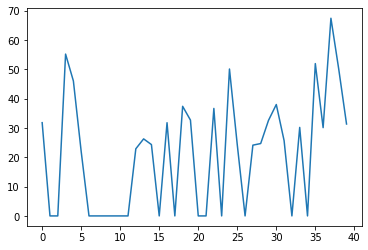

In [31]:
plt.plot(n_epe)

## Categories

TC


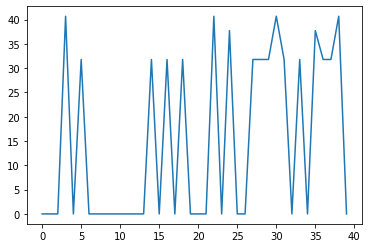

40
0.01228563256469295 False no trend
0.0 0.0
TUTT


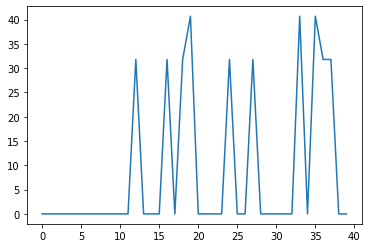

40
0.04764589634816807 False no trend
0.0 0.0
Mid-tro


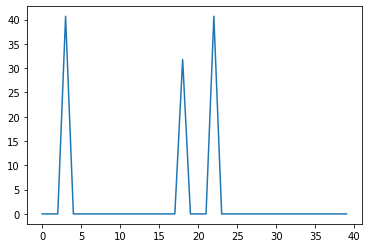

40
0.44155610347286145 False no trend
0.0 0.0
surge


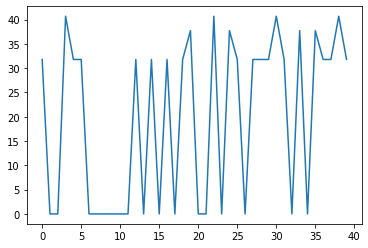

40
0.0330108521038337 False no trend
0.0 31.789721187869354
MCS


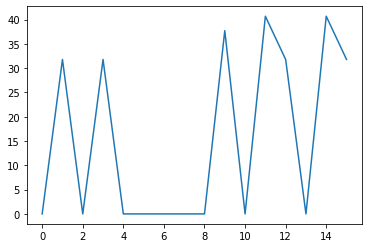

16
0.15712267825329662 False no trend
0.0 0.0
Front


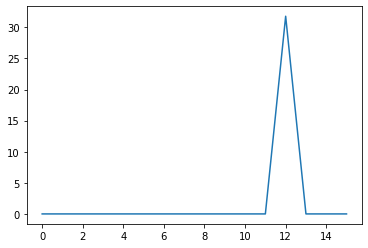

16
0.385546631571102 False no trend
0.0 0.0


In [32]:
inspect_categoy_precip_rate(sub_id=1)

# Sub2

In [33]:
sub_id = 2
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.07921221657854227 False no trend
0.0 0.0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.820
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.101
Time:                        15:31:53   Log-Likelihood:                -172.01
No. Observations:                  40   AIC:                             348.0
Df Residuals:                      38   BIC:                             351.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

In [34]:
sub_id = 2
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    if len(ext_time)>0:
        n_epe.append(np.sum(ext_precip.data)/len(ext_time)) # daily precipitation rates
    else:
        n_epe.append(0)
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

40
0.03826387493174388 True decreasing
0.0 0.0


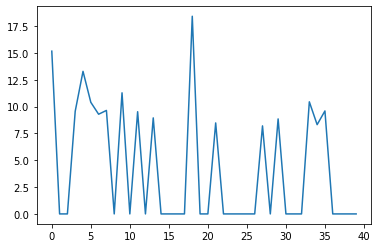

In [35]:
plt.plot(n_epe)

In [36]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.937
Date:                Fri, 02 Jun 2023   Prob (F-statistic):             0.0545
Time:                        15:31:53   Log-Likelihood:                -122.71
No. Observations:                  40   AIC:                             249.4
Df Residuals:                      38   BIC:                             252.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0653      1.656      4.266      0.0

## Categories

TC


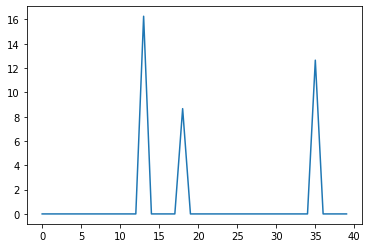

40
0.7388551076431218 False no trend
0.0 0.0
TUTT


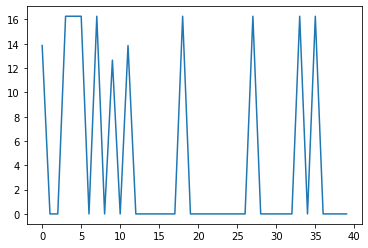

40
0.08504816960894357 False no trend
0.0 0.0
Mid-tro


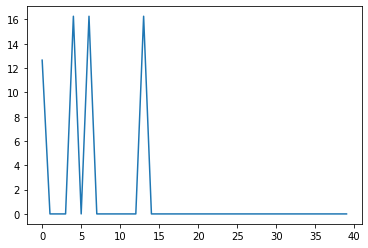

40
0.01701446723182487 False no trend
0.0 0.0
surge


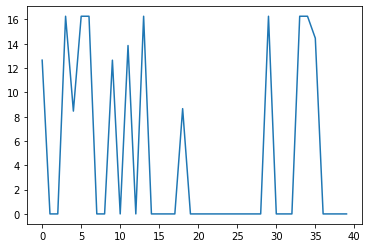

40
0.18461921540801707 False no trend
0.0 0.0
MCS


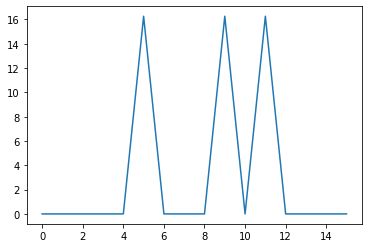

16
0.7878764949099475 False no trend
0.0 0.0
Front


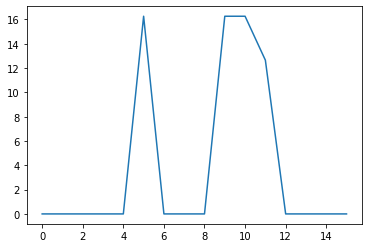

16
0.7184694726790863 False no trend
0.0 0.0


In [37]:
inspect_categoy_precip_rate(sub_id=2)

# Sub3

In [38]:
sub_id = 3
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.16087806893207057 False no trend
0.0 0.0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.733
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.107
Time:                        15:31:55   Log-Likelihood:                -164.03
No. Observations:                  40   AIC:                             332.1
Df Residuals:                      38   BIC:                             335.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

In [39]:
sub_id = 3
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    if len(ext_time)>0:
        n_epe.append(np.sum(ext_precip.data)/len(ext_time)) # daily precipitation rates
    else:
        n_epe.append(0)
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

40
0.2323206137486693 False no trend
0.0 0.0


## Categories

TC


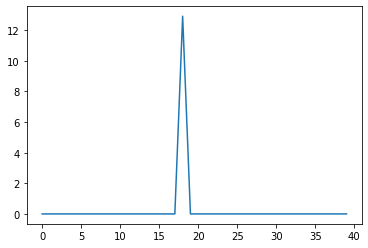

40
0.9309659239347461 False no trend
0.0 0.0
TUTT


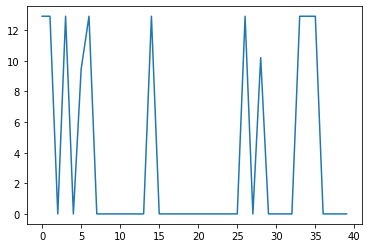

40
0.3919230382269383 False no trend
0.0 0.0
Mid-tro


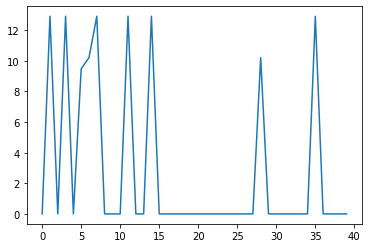

40
0.03977628756621909 False no trend
0.0 0.0
surge


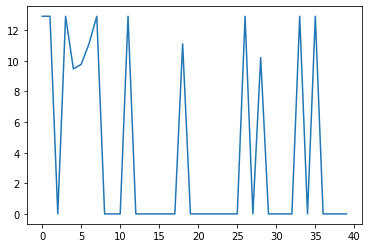

40
0.04101262461467203 False no trend
0.0 0.0
MCS


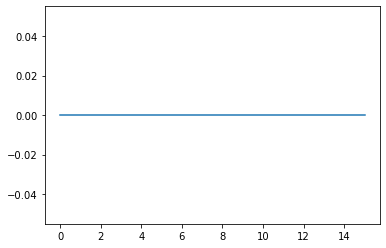

16
1.0 False no trend
0.0 0.0
Front


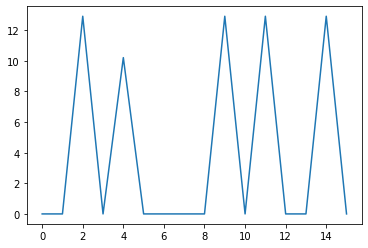

16
0.7814020111966875 False no trend
0.0 0.0


In [40]:
inspect_categoy_precip_rate(sub_id=3)

# Sub4

In [41]:
sub_id = 4
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.14927118153783514 False no trend
0.2412777143351921 9.044585832944767
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.295
Date:                Fri, 02 Jun 2023   Prob (F-statistic):             0.0451
Time:                        15:31:57   Log-Likelihood:                -163.98
No. Observations:                  40   AIC:                             332.0
Df Residuals:                      38   BIC:                             335.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

(array([ 6.,  8., 10.,  4.,  4.,  2.,  3.,  1.,  1.,  1.]),
 array([-4.5991    ,  1.91165735,  8.42241471, 14.93317206, 21.44392941,
        27.95468676, 34.46544412, 40.97620147, 47.48695882, 53.99771618,
        60.50847353]),
 <BarContainer object of 10 artists>)

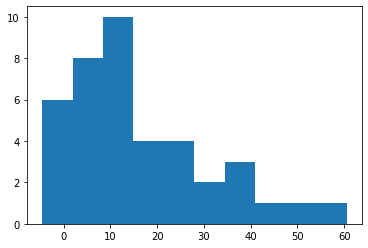

In [42]:
res = np.array(n_epe)-0.4251*np.arange(n)+8.1539
plt.hist(res)

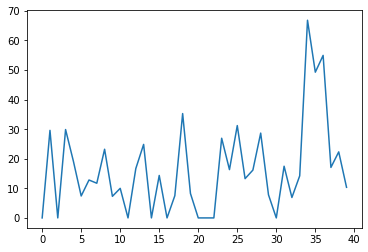

In [43]:
plt.plot(n_epe)

In [44]:
sub_id = 4
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    if len(ext_time)>0:
        n_epe.append(np.sum(ext_precip.data)/len(ext_time)) # daily precipitation rates
    else:
        n_epe.append(0)
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

40
0.27554742158263257 False no trend
0.023464179171801176 7.167693853713744


## Categories

TC


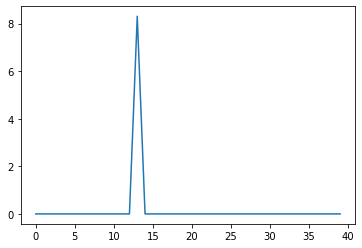

40
0.6032185250817323 False no trend
0.0 0.0
TUTT


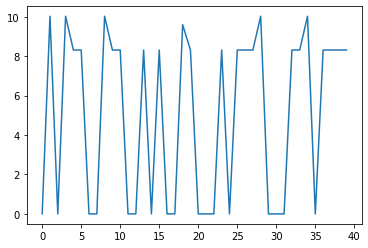

40
0.6934107734598709 False no trend
0.0 8.310499243686596
Mid-tro


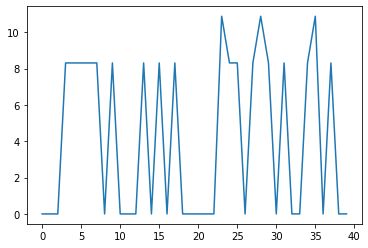

40
0.7322047942537941 False no trend
0.0 0.0
surge


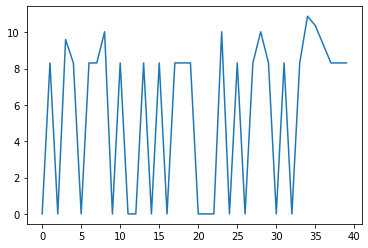

40
0.13586629420149032 False no trend
0.0 8.310499243686596
MCS


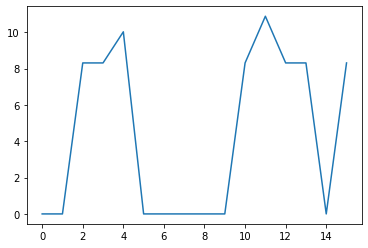

16
0.36792059566139645 False no trend
0.0 4.155249621843298
Front


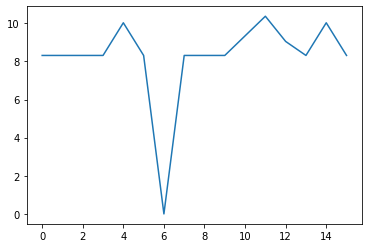

16
0.1755035084518246 False no trend
0.0 8.310499243686596


In [45]:
inspect_categoy_precip_rate(sub_id=4)

# Sub5

In [46]:
sub_id = 5
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.9257196644596948 False no trend
-0.018335334972307868 21.82985987541472
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7370
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.396
Time:                        15:31:59   Log-Likelihood:                -176.81
No. Observations:                  40   AIC:                             357.6
Df Residuals:                      38   BIC:                             361.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [47]:
sub_id = 5
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    if len(ext_time)>0:
        n_epe.append(np.sum(ext_precip.data)/len(ext_time)) # daily precipitation rates
    else:
        n_epe.append(0)
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

40
0.7976523531872495 False no trend
-0.005214613108725567 8.542917581112775


## categories

TC


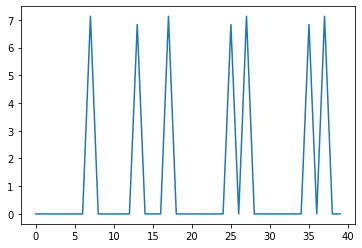

40
0.3953304703229028 False no trend
0.0 0.0
TUTT


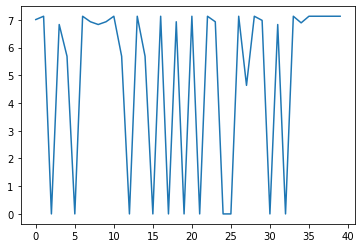

40
0.21088141533426596 False no trend
0.0 6.930208602556515
Mid-tro


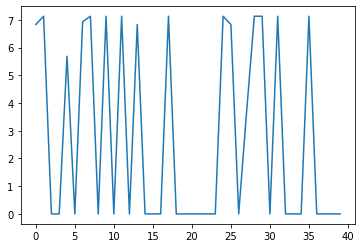

40
0.357045073412797 False no trend
0.0 0.0
surge


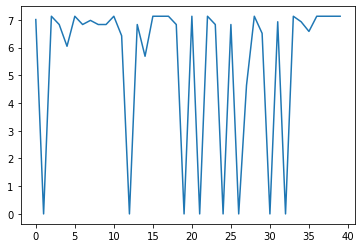

40
0.6216350993163293 False no trend
0.0 6.830806383623608
MCS


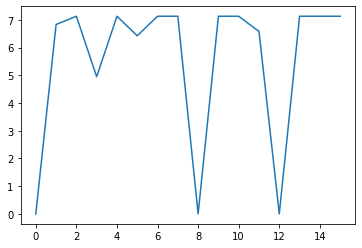

16
0.26993057936897213 False no trend
0.0 7.129013040422329
Front


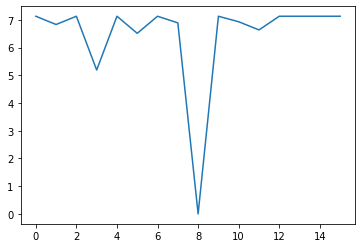

16
0.39611121826440376 False no trend
0.0 7.129013040422329


In [48]:
inspect_categoy_precip_rate(sub_id=5)

# Sub6

In [49]:
sub_id = 6
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.017954626824179698 True increasing
1.0317938286683521 11.807173366586134
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.750
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.194
Time:                        15:32:03   Log-Likelihood:                -203.32
No. Observations:                  40   AIC:                             410.6
Df Residuals:                      38   BIC:                             414.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

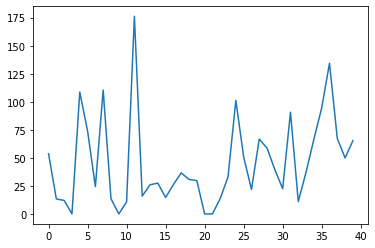

In [50]:
plt.plot(n_epe)

In [51]:
sub_id = 6
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    if len(ext_time)>0:
        n_epe.append(np.sum(ext_precip.data)/len(ext_time)) # daily precipitation rates
    else:
        n_epe.append(0)
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

40
0.07447928615112631 False no trend
0.06467282864898871 12.120492462880465


## Catrgories

TC


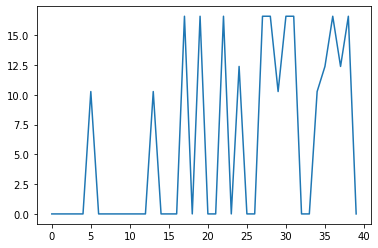

40
0.0016704563769280867 True increasing
0.0 0.0
TUTT


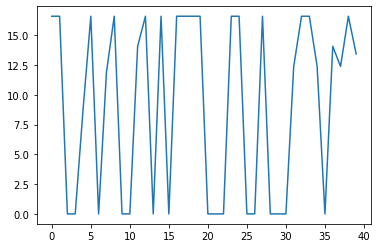

40
0.9102545856854143 False no trend
0.0 12.383796871027078
Mid-tro


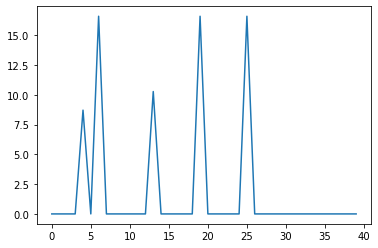

40
0.26203557573909686 False no trend
0.0 0.0
surge


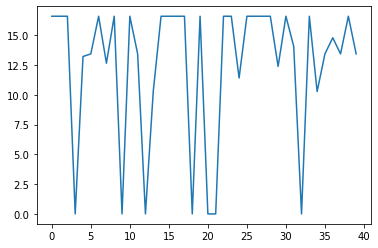

40
0.8020971593338924 False no trend
0.0 15.695469270535586
MCS


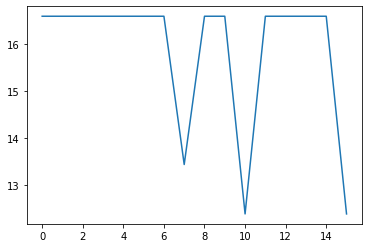

16
0.18112421023103198 False no trend
0.0 16.598652652219723
Front


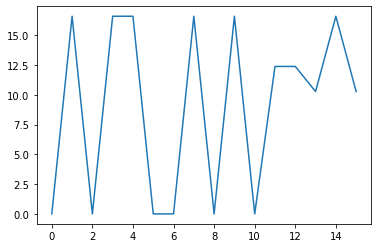

16
0.8104670457043044 False no trend
0.0 11.330082925728917


In [52]:
inspect_categoy_precip_rate(sub_id=6)

# Sub7

In [53]:
sub_id = 7
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.13577683650623618 False no trend
-1.35819106853177 121.87959361954304
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.777
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.104
Time:                        15:32:06   Log-Likelihood:                -218.38
No. Observations:                  40   AIC:                             440.8
Df Residuals:                      38   BIC:                             444.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

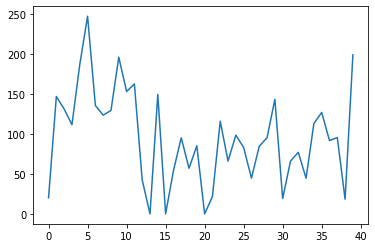

In [54]:
plt.plot(n_epe)

In [55]:
sub_id = 7
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    if len(ext_time)>0:
        n_epe.append(np.sum(ext_precip.data)/len(ext_time)) # daily precipitation rates
    else:
        n_epe.append(0)
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

40
0.761888096774634 False no trend
-0.011370793487971521 23.304587499888026


## categories

TC


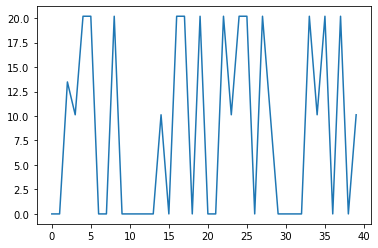

40
0.5565171869577636 False no trend
0.0 5.0631551399038965
TUTT


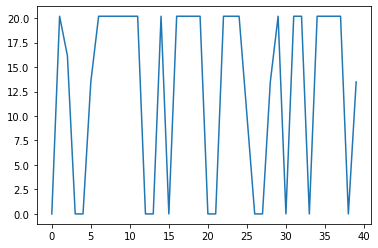

40
0.7634252193482514 False no trend
0.0 20.19059173266093
Mid-tro


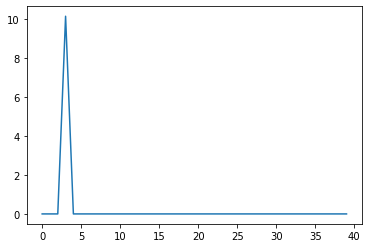

40
0.16572435076856773 False no trend
0.0 0.0
surge


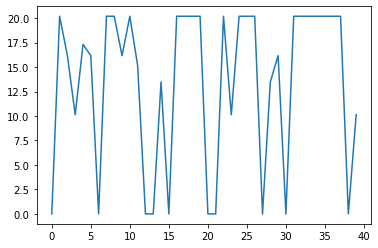

40
0.34927834457377527 False no trend
0.0 16.73998094882557
MCS


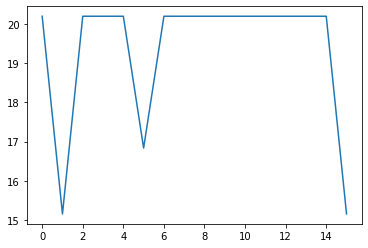

16
0.9468077134830775 False no trend
0.0 20.19059173266093
Front


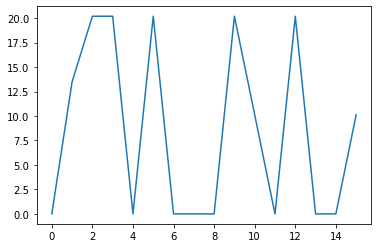

16
0.6215433787753633 False no trend
0.0 5.0631551399038965


In [56]:
inspect_categoy_precip_rate(sub_id=7)